#IMPORT

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import drive
import os

#CONEXÇÂO COM O DRIVE

In [2]:
import os
HOME_DIR = os.getcwd()
print(HOME_DIR)

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

HOME_DIR = '/content/gdrive/MyDrive/Colab Notebooks'
os.chdir(os.path.join(HOME_DIR, "dataset"))

!pwd
dataset_dir = '/content/gdrive/MyDrive/Colab Notebooks/dataset'

positive_dir = os.path.join(dataset_dir, 'Positive')
negative_dir = os.path.join(dataset_dir, 'Negative')

/content
Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/dataset


#FILTROS A SEREM TESTADOS

In [3]:
def high_frequency_filter(image):
    # Ensure image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    return cv2.filter2D(image, -1, kernel)

def sobel_filter(image):
    # Ensure image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Derivada x
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Derivada y
    sobel = cv2.magnitude(sobelx, sobely)
    sobel = cv2.convertScaleAbs(sobel)
    return sobel

def laplacian_filter(image):
    # Ensure image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    laplacian = cv2.convertScaleAbs(laplacian)  # Converte para uint8
    return laplacian

def highboost_filter(image, A=1.5):
    # Ensure image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # GaussianBlur and subsequent operations work on grayscale
    blurred = cv2.GaussianBlur(image, (5,5), 0)
    mask = cv2.subtract(image, blurred)
    highboost = cv2.addWeighted(image, A, mask, 1 - A, 0) # Corrected alpha for mask
    return highboost

def sharpen_image(image):
    # Ensure image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

def histogram_equalization(image):
    # Ensure image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # equalizeHist works on grayscale
    equalized = cv2.equalizeHist(image)
    return equalized

def gamma_correction(image, gamma=1.0):
    # Ensure image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply LUT on grayscale image
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

#MANIPULAÇÂO COM O DATASET POSITIVE

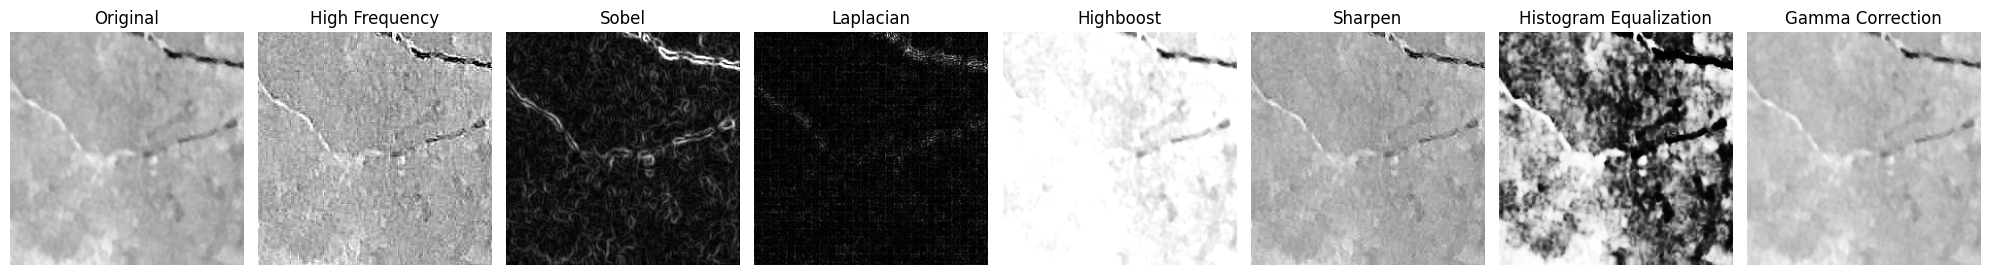

In [4]:
def get_first_png_image(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith('.jpg'):
            return os.path.join(folder_path, file)
    return None

positive_image_path = get_first_png_image(positive_dir)

positive_img = cv2.imread(positive_image_path, cv2.IMREAD_GRAYSCALE)

results = {
    "Original": positive_img,
    "High Frequency": high_frequency_filter(positive_img),
    "Sobel": sobel_filter(positive_img),
    "Laplacian": laplacian_filter(positive_img),
    "Highboost": highboost_filter(positive_img),
    "Sharpen": sharpen_image(positive_img),
    "Histogram Equalization": histogram_equalization(positive_img),
    "Gamma Correction": gamma_correction(positive_img, gamma=1.5)
}

# Configura o plot
plt.figure(figsize=(20, 10))  # Ajuste o tamanho conforme necessário
num_images = len(results)

# Plota cada imagem em uma linha
for i, (title, img) in enumerate(results.items()):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img, cmap='gray' if len(img.shape) == 2 or img.shape[2] == 1 else None)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

#MANIPULAÇÃO COM O DATASET NEGATIVE

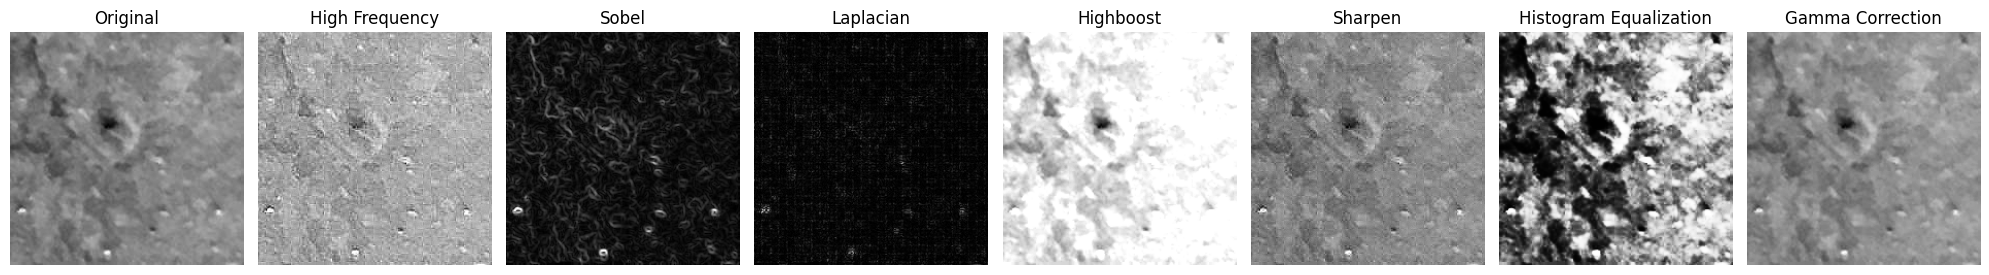

In [5]:
negative_image_path = get_first_png_image(negative_dir)
negative_img = cv2.imread(negative_image_path, cv2.IMREAD_GRAYSCALE)

results = {
    "Original": negative_img,
    "High Frequency": high_frequency_filter(negative_img),
    "Sobel": sobel_filter(negative_img),
    "Laplacian": laplacian_filter(negative_img),
    "Highboost": highboost_filter(negative_img),
    "Sharpen": sharpen_image(negative_img),
    "Histogram Equalization": histogram_equalization(negative_img),
    "Gamma Correction": gamma_correction(negative_img, gamma=1.5)
}

# Configura o plot
plt.figure(figsize=(20, 10))  # Ajuste o tamanho conforme necessário
num_images = len(results)

# Plota cada imagem em uma linha
for i, (title, img) in enumerate(results.items()):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img, cmap='gray' if len(img.shape) == 2 or img.shape[2] == 1 else None)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

#SEPARAÇÃO DO DATASET DE TREINO E TEST

In [ ]:
# Tamanho reduzido da imagem
img_size = (64, 64)

# Função para carregar imagens
def load_images_from_folder(folder, label, max_images=None):
    images = []
    labels = []
    count = 0
    for filename in tqdm(os.listdir(folder), desc=f'Loading {label}'):
        if filename.lower().endswith('.jpg'):
            path = os.path.join(folder, filename)
            img = cv2.imread(path)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)
                count += 1
                if max_images and count >= max_images:
                    break
    return images, labels

# Carregar até 20.000 positivas
positive_imgs, positive_labels = load_images_from_folder(positive_dir, label='Positive', max_images=20000)

# Carregar todas as negativas
negative_imgs, negative_labels = load_images_from_folder(negative_dir, label='Negative')

# Concatenar tudo
all_images = np.array(positive_imgs + negative_imgs)
all_labels = np.array(positive_labels + negative_labels)

print("Total de imagens:", all_images.shape)
print("Total de labels:", all_labels.shape)

# Separar em treino/teste
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print("Train:", train_images.shape, train_labels.shape)
print("Test:", test_images.shape, test_labels.shape)

Loading Positive:   1%|          | 208/20001 [04:31<151:30:14, 27.56s/it]

#SALVAR OS DATASET NO DRIVE DEPOIS DE MANIPULAR

In [ ]:
# Diretórios de saída no Google Drive
output_base_dir = '/content/gdrive/MyDrive/Colab Notebooks/dataset'
os.makedirs(output_base_dir, exist_ok=True)

# Pastas para treino/teste
train_dir = os.path.join(output_base_dir, 'train')
test_dir = os.path.join(output_base_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Subpastas para Positive/Negative
for label in ['Positive', 'Negative']:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Função para aplicar filtros conforme a label
def apply_filter(img, label):
    if label == 'Positive':
        return high_frequency_filter(img)  # Filtro para Positive
    elif label == 'Negative':
        return sharpen_image(img)         # Filtro para Negative

# Processar e salvar imagens de treino
for i, (img, label) in tqdm(enumerate(zip(train_images, train_labels)), desc="Processing Train"):
    filtered_img = apply_filter(img, label)
    cv2.imwrite(os.path.join(train_dir, label, f'train_{i}.jpg'), filtered_img)

# Processar e salvar imagens de teste
for i, (img, label) in tqdm(enumerate(zip(test_images, test_labels)), desc="Processing Test"):
    filtered_img = apply_filter(img, label)
    cv2.imwrite(os.path.join(test_dir, label, f'test_{i}.jpg'), filtered_img)

print("Imagens processadas e salvas no Google Drive!")